In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 8.1MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 7.4MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-03 18:39:32--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-03 18:39:32--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9ca15615a8bf4f77144bb3b7ac.dl.dropboxusercontent.com/cd/0/get/BJ-ODxkHvwlBeEMCO282dAKnTOweBifpiWT5-qo7R1PIchNDRbJHw3OaINl7rOcitK88PZNdwU-xc84FN2rtPsFbXsb9kH4UI1FMy3FEDrVQEgzUHuOq4MVheeKOzocZZWM/file?dl=1# [following]
--2021-03-03 18:39:33--  https://uc9ca15615a8bf4f77144bb3b7ac.dl.dropboxusercontent.com/cd/0/get/BJ-ODxkHvwlBeEMCO282dAKnTOweBifpiWT5-qo7R1PIchNDRbJHw3OaINl7rOcitK88PZNdwU-xc84FN2rtP

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo='resnest101e'

## Ranger

In [10]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [11]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest101-22405ba7.pth" to /root/.cache/torch/hub/checkpoints/resnest101-22405ba7.pth


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=6.309573450380412e-07)

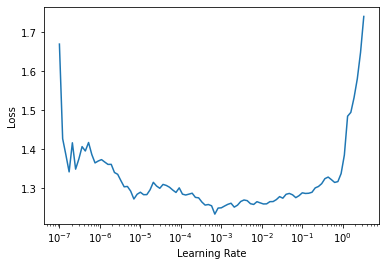

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.308788,0.924019,0.501529,0.489247,0.572327,01:15
1,1.223329,0.918394,0.512232,0.498834,0.672956,01:14


Better model found at epoch 0 with valid_loss value: 0.9240188002586365.


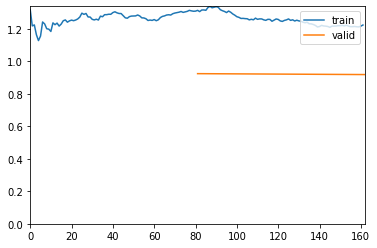

Better model found at epoch 1 with valid_loss value: 0.9183937311172485.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.232009,0.908438,0.527523,0.510112,0.713836,01:37
1,1.173591,0.885133,0.527523,0.511688,0.619497,01:35
2,1.169909,0.843340,0.519878,0.505714,0.556604,01:35
3,1.188812,0.830881,0.533639,0.518207,0.581761,01:35
4,1.146802,0.838027,0.527523,0.511057,0.654088,01:35
5,1.119016,0.803302,0.556575,0.538674,0.613208,01:35
6,1.127128,0.799087,0.547401,0.531250,0.588050,01:36
7,1.080755,0.789347,0.548930,0.532213,0.597484,01:35
8,1.082068,0.769176,0.562691,0.548485,0.569182,01:35
9,1.100713,0.778941,0.568807,0.545000,0.685535,01:35


Better model found at epoch 0 with valid_loss value: 0.9084376692771912.


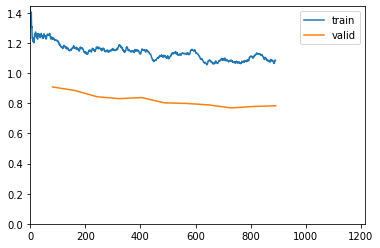

Better model found at epoch 1 with valid_loss value: 0.8851327896118164.
Better model found at epoch 2 with valid_loss value: 0.8433399200439453.
Better model found at epoch 3 with valid_loss value: 0.8308811783790588.
Better model found at epoch 5 with valid_loss value: 0.8033016324043274.
Better model found at epoch 6 with valid_loss value: 0.7990866303443909.
Better model found at epoch 7 with valid_loss value: 0.7893468737602234.
Better model found at epoch 8 with valid_loss value: 0.7691760063171387.
No improvement since epoch 8: early stopping


In [13]:
learn.fine_tune(15,freeze_epochs=2)

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

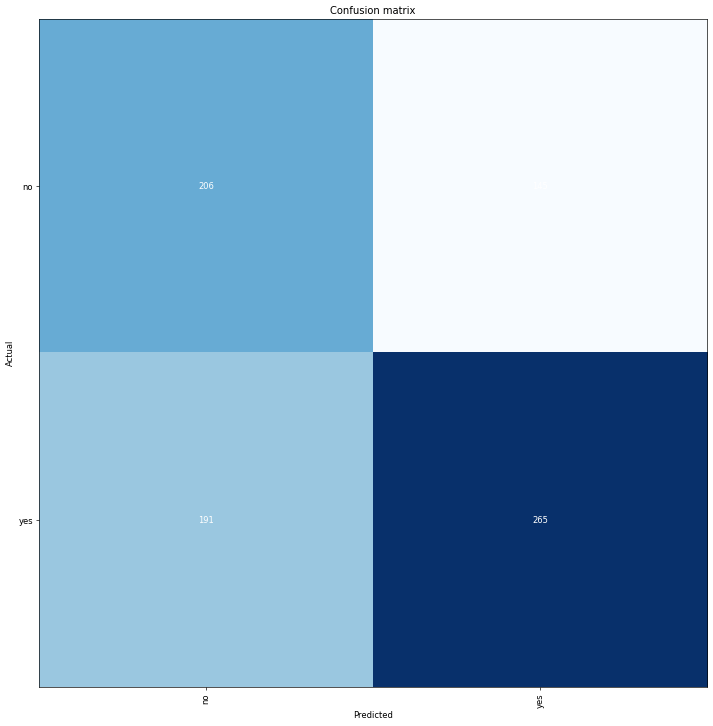

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5836431384086609.


(#4) [0.7416687607765198,0.5836431384086609,0.6463414634146342,0.581140350877193]

## Faltten

In [17]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.249136,0.851983,0.591743,0.572238,0.635220,01:13
1,0.931923,0.690192,0.639144,0.646429,0.569182,01:13


Better model found at epoch 0 with valid_loss value: 0.8519833087921143.


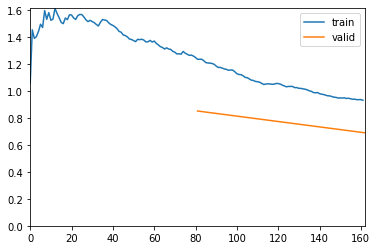

Better model found at epoch 1 with valid_loss value: 0.6901918053627014.


In [18]:
learn.fit_flat_cos(2,lr=1e-3)

In [19]:
learn.unfreeze()

SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=1.0964781722577754e-06)

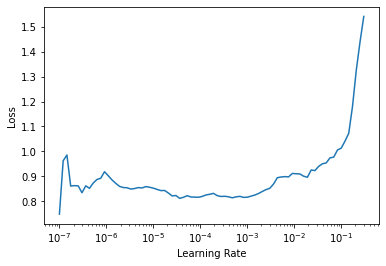

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.041396,29.609488,0.510703,0.473684,0.056604,01:32
1,1.045471,2.659100,0.500000,0.491620,0.830189,01:32
2,1.092592,1.931332,0.518349,0.534884,0.072327,01:32
3,1.068449,1.519169,0.475535,0.480499,0.968553,01:32
4,1.124244,1.247668,0.486239,0.486239,1.000000,01:32
5,1.033985,0.860852,0.509174,0.421053,0.025157,01:32
6,0.989479,1.102826,0.477064,0.472851,0.657233,01:32
7,0.961017,1.084647,0.487768,0.486572,0.968553,01:32
8,0.965749,1.994085,0.510703,0.400000,0.012579,01:32


Better model found at epoch 0 with valid_loss value: 29.609487533569336.


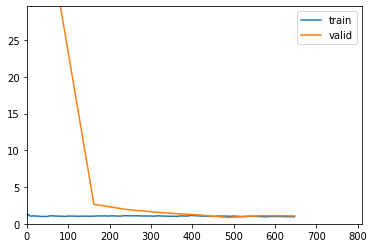

Better model found at epoch 1 with valid_loss value: 2.659100294113159.
Better model found at epoch 2 with valid_loss value: 1.931331753730774.
Better model found at epoch 3 with valid_loss value: 1.519168734550476.
Better model found at epoch 4 with valid_loss value: 1.2476680278778076.
Better model found at epoch 5 with valid_loss value: 0.8608523607254028.
No improvement since epoch 5: early stopping


In [21]:
learn.fit_flat_cos(10,lr=1e-2)

In [22]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

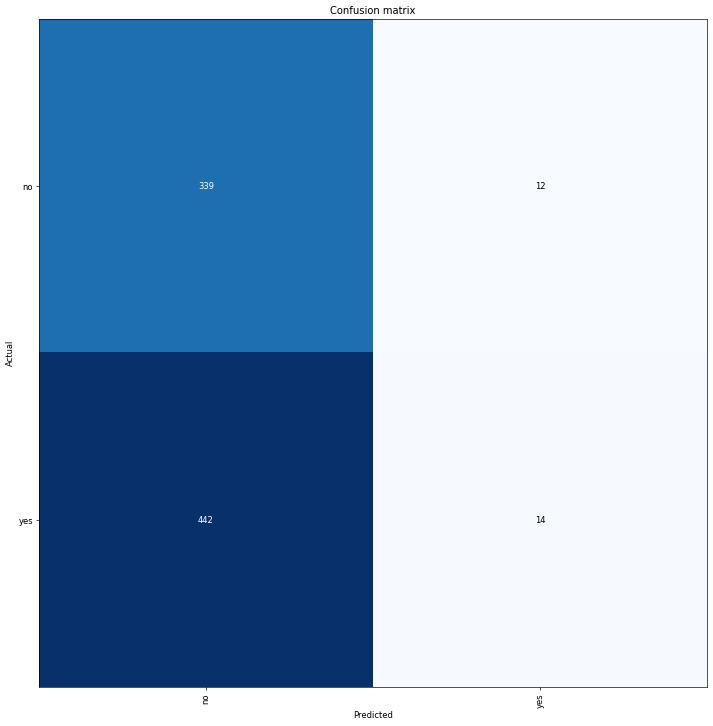

In [23]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [24]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4374225437641144.


(#4) [0.8293555378913879,0.4374225437641144,0.5384615384615384,0.03070175438596491]

## LabelSmoothing

In [25]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=3.0199516913853586e-05)

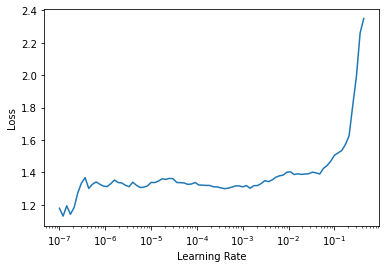

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.297405,1.214359,0.571865,0.542793,0.757862,01:14
1,1.113077,0.733362,0.551988,0.544484,0.481132,01:13


Better model found at epoch 0 with valid_loss value: 1.214359164237976.


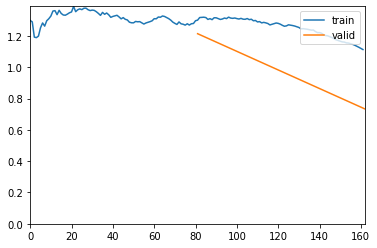

Better model found at epoch 1 with valid_loss value: 0.7333624362945557.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.806816,0.673889,0.610092,0.609756,0.550314,01:35
1,0.761577,0.678581,0.591743,0.602410,0.471698,01:35
2,0.724562,0.646122,0.657492,0.627717,0.726415,01:34
3,0.687568,0.646751,0.663609,0.691406,0.556604,01:34
4,0.665661,0.630606,0.654434,0.648387,0.632075,01:34
5,0.636066,0.609140,0.691131,0.719697,0.597484,01:35
6,0.622578,0.610843,0.681957,0.706767,0.591195,01:34
7,0.598566,0.585838,0.721713,0.739437,0.660377,01:34
8,0.590483,0.586282,0.709480,0.746154,0.610063,01:35
9,0.572617,0.589343,0.732416,0.763838,0.650943,01:34


Better model found at epoch 0 with valid_loss value: 0.6738889813423157.


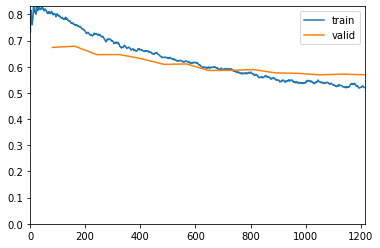

Better model found at epoch 2 with valid_loss value: 0.6461216807365417.
Better model found at epoch 4 with valid_loss value: 0.6306061148643494.
Better model found at epoch 5 with valid_loss value: 0.6091399788856506.
Better model found at epoch 7 with valid_loss value: 0.5858379006385803.
Better model found at epoch 10 with valid_loss value: 0.5765939354896545.
Better model found at epoch 11 with valid_loss value: 0.5747888088226318.
Better model found at epoch 12 with valid_loss value: 0.5691551566123962.


In [27]:
learn.fine_tune(15,freeze_epochs=2)

In [28]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

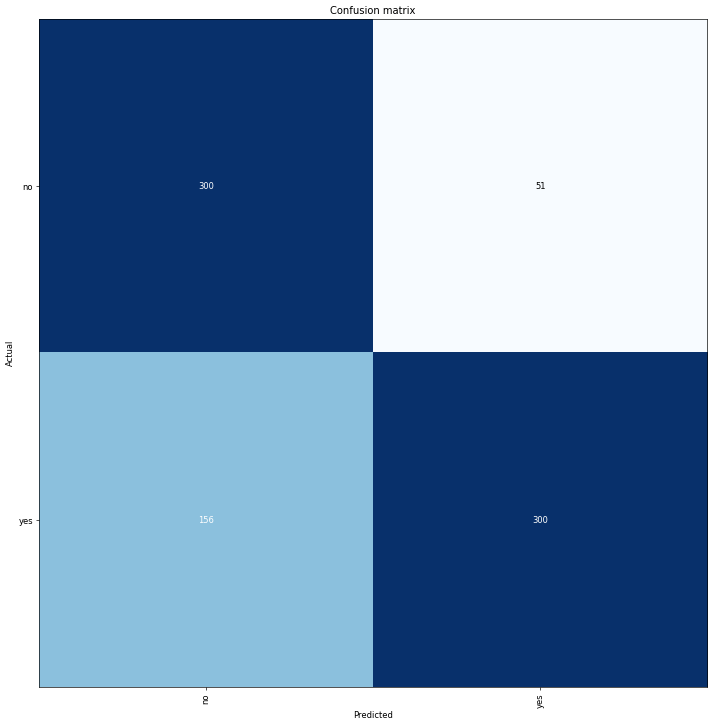

In [29]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [30]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.74349445104599.


(#4) [0.5491921901702881,0.74349445104599,0.8547008547008547,0.6578947368421053]

## MixUp

In [31]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [32]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.429738,0.963799,0.600917,0.572519,0.707547,01:14
1,1.157194,0.786031,0.561162,0.563265,0.433962,01:13


Better model found at epoch 0 with valid_loss value: 0.9637985825538635.


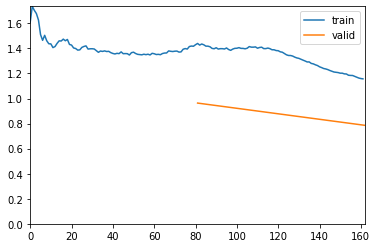

Better model found at epoch 1 with valid_loss value: 0.7860307097434998.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.840793,0.699914,0.555046,0.544554,0.518868,01:35
1,0.793658,0.674222,0.590214,0.625000,0.393082,01:35
2,0.748455,0.643317,0.608563,0.584239,0.676101,01:35
3,0.722508,0.662888,0.585627,0.551422,0.792453,01:35
4,0.691758,0.622973,0.659021,0.743590,0.455975,01:35
5,0.674005,0.623964,0.657492,0.658784,0.613208,01:35
6,0.643060,0.608054,0.666667,0.740385,0.484277,01:35
7,0.639120,0.567876,0.689602,0.740586,0.556604,01:35
8,0.621350,0.566364,0.714067,0.707937,0.701258,01:35
9,0.606056,0.554738,0.724771,0.731544,0.685535,01:35


Better model found at epoch 0 with valid_loss value: 0.699914276599884.


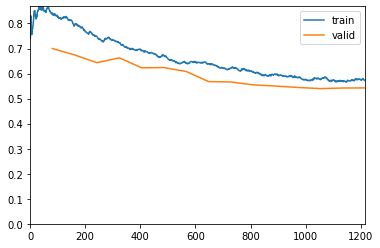

Better model found at epoch 1 with valid_loss value: 0.674222469329834.
Better model found at epoch 2 with valid_loss value: 0.6433171033859253.
Better model found at epoch 4 with valid_loss value: 0.6229726076126099.
Better model found at epoch 6 with valid_loss value: 0.6080536246299744.
Better model found at epoch 7 with valid_loss value: 0.5678755044937134.
Better model found at epoch 8 with valid_loss value: 0.5663641691207886.
Better model found at epoch 9 with valid_loss value: 0.55473792552948.
Better model found at epoch 10 with valid_loss value: 0.5500919222831726.
Better model found at epoch 11 with valid_loss value: 0.5444818139076233.
Better model found at epoch 12 with valid_loss value: 0.5398902297019958.


In [33]:
learn.fine_tune(15,freeze_epochs=2)

In [34]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

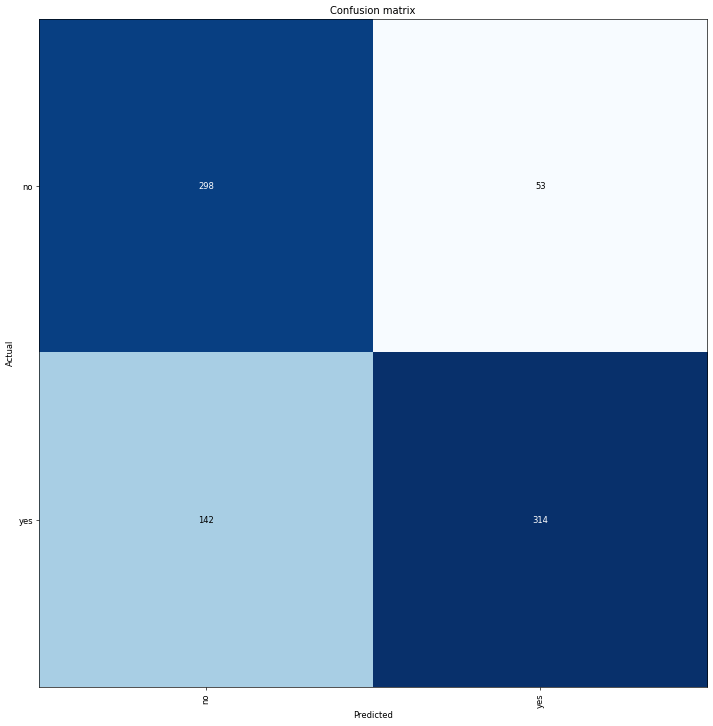

In [35]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [36]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7583643198013306.


(#4) [0.4971577823162079,0.7583643198013306,0.8555858310626703,0.6885964912280702]

## Ranger + Flat cosin Anneal

In [37]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.302207,0.903287,0.506116,0.492958,0.550314,01:14
1,1.295452,0.880193,0.545872,0.527559,0.632075,01:14


Better model found at epoch 0 with valid_loss value: 0.903286874294281.


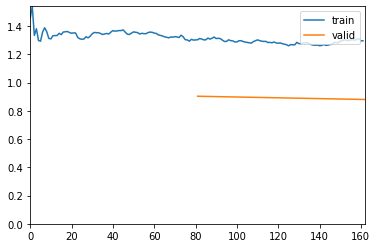

Better model found at epoch 1 with valid_loss value: 0.8801930546760559.


In [38]:
learn.fit_flat_cos(2,lr=1e-3)

In [39]:
learn.unfreeze()

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=8.31763736641733e-06)

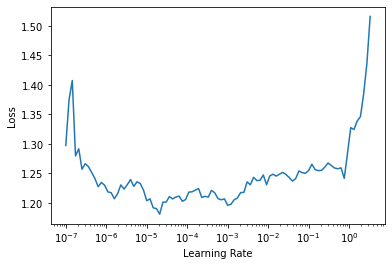

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.209934,0.902344,0.533639,0.518519,0.572327,01:35
1,1.114041,0.819580,0.519878,0.506536,0.487421,01:36
2,0.997086,0.755747,0.518349,0.503876,0.613208,01:35
3,0.879985,0.718858,0.519878,0.505882,0.540881,01:35
4,0.805207,0.722776,0.532110,0.518987,0.515723,01:35
5,0.760742,0.775153,0.509174,0.496021,0.588050,01:35
6,0.734268,0.730030,0.510703,0.498047,0.801887,01:35


Better model found at epoch 0 with valid_loss value: 0.9023440480232239.


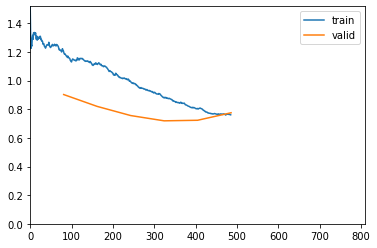

Better model found at epoch 1 with valid_loss value: 0.8195801973342896.
Better model found at epoch 2 with valid_loss value: 0.755747377872467.
Better model found at epoch 3 with valid_loss value: 0.7188580632209778.
No improvement since epoch 3: early stopping


In [41]:
learn.fit_flat_cos(10,lr=1e-2)

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [43]:
learn.dls = dlsTest

In [44]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5439900755882263.


(#4) [0.7144746780395508,0.5439900755882263,0.602803738317757,0.5657894736842105]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [45]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.352071,0.984197,0.516820,0.502538,0.622642,01:14
1,1.327329,0.947603,0.516820,0.502732,0.578616,01:14


Better model found at epoch 0 with valid_loss value: 0.9841973781585693.


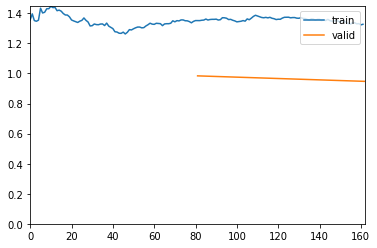

Better model found at epoch 1 with valid_loss value: 0.9476029276847839.


In [46]:
learn.fit_flat_cos(2,lr=1e-3)

In [47]:
learn.unfreeze()

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=1.9054607491852948e-06)

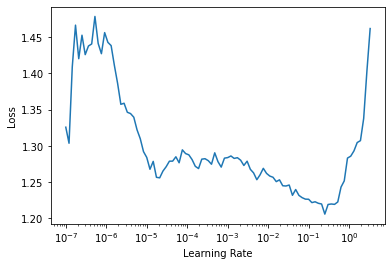

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.209354,0.901959,0.490826,0.476923,0.487421,01:35
1,1.131060,0.792533,0.544343,0.537594,0.449686,01:35
2,0.991009,1.607792,0.498471,0.464286,0.204403,01:35
3,0.874575,0.718282,0.498471,0.486264,0.556604,01:35
4,0.802510,0.820987,0.483180,0.461832,0.380503,01:35
5,0.763423,0.987601,0.480122,0.479478,0.808176,01:35
6,0.750190,0.734324,0.509174,0.497053,0.795597,01:35


Better model found at epoch 0 with valid_loss value: 0.9019589424133301.


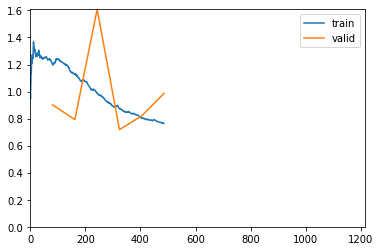

Better model found at epoch 1 with valid_loss value: 0.7925332188606262.
Better model found at epoch 3 with valid_loss value: 0.718281626701355.
No improvement since epoch 3: early stopping


In [49]:
learn.fit_flat_cos(15,lr=1e-2)

In [50]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [51]:
learn.dls = dlsTest

In [52]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.537794291973114.


(#4) [0.7098255753517151,0.537794291973114,0.5884861407249466,0.6052631578947368]

## Ranger +Flat + Label + MixUp

In [53]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.333105,0.936179,0.506116,0.491289,0.443396,01:14
1,1.249940,0.919484,0.519878,0.507937,0.402516,01:14


Better model found at epoch 0 with valid_loss value: 0.9361791610717773.


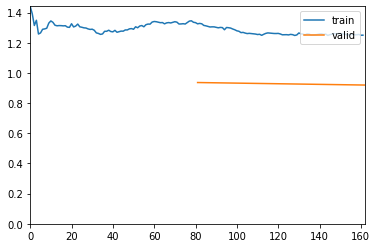

Better model found at epoch 1 with valid_loss value: 0.9194844365119934.


In [54]:
learn.fit_flat_cos(2,lr=1e-3)

In [55]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.217638,0.839389,0.515290,0.501259,0.625786,01:35
1,1.098559,0.783260,0.536697,0.519481,0.628931,01:35
2,0.990818,0.717510,0.568807,0.546154,0.669811,01:36
3,0.868955,0.716138,0.524465,0.507761,0.720126,01:35
4,0.800965,0.718475,0.519878,0.507042,0.452830,01:36
5,0.752484,0.694024,0.544343,0.543860,0.389937,01:35
6,0.720716,0.687560,0.568807,0.620000,0.292453,01:36
7,0.715281,0.684391,0.573394,0.553719,0.632075,01:35
8,0.711570,0.689095,0.542813,0.540773,0.396226,01:36
9,0.698112,0.687713,0.544343,0.540650,0.418239,01:35


Better model found at epoch 0 with valid_loss value: 0.839389443397522.


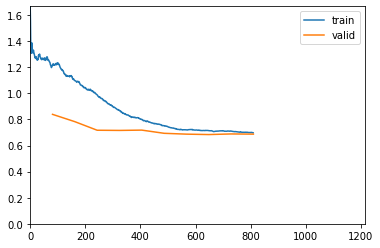

Better model found at epoch 1 with valid_loss value: 0.7832600474357605.
Better model found at epoch 2 with valid_loss value: 0.7175096869468689.
Better model found at epoch 3 with valid_loss value: 0.7161375880241394.
Better model found at epoch 5 with valid_loss value: 0.6940237283706665.
Better model found at epoch 6 with valid_loss value: 0.6875597834587097.
Better model found at epoch 7 with valid_loss value: 0.6843905448913574.
No improvement since epoch 7: early stopping


In [56]:
learn.fit_flat_cos(15,lr=1e-2)

In [57]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

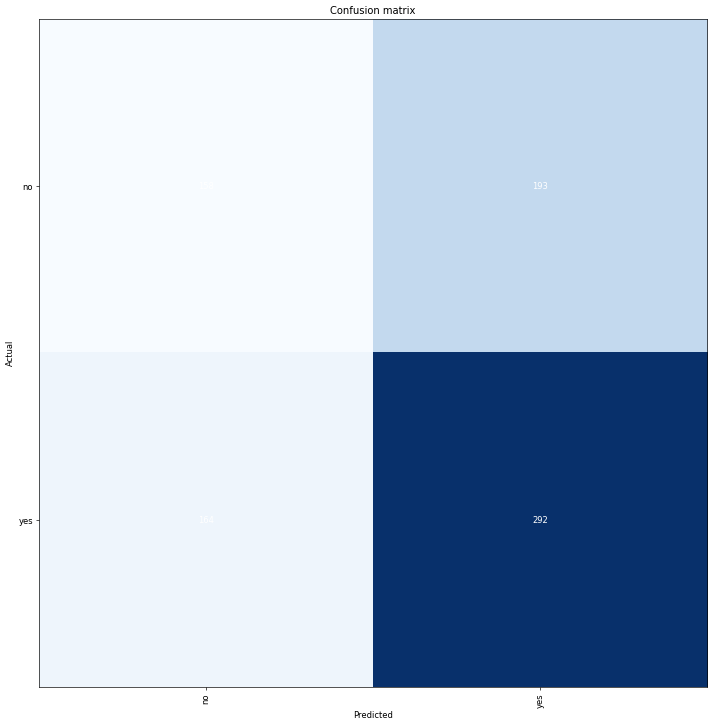

In [58]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [59]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5576208233833313.


(#4) [0.6794976592063904,0.5576208233833313,0.6020618556701031,0.6403508771929824]

## Ranger + Flat + MixUp

In [60]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [61]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.334343,0.955250,0.493884,0.476364,0.411950,01:14
1,1.301457,0.961616,0.489297,0.464286,0.327044,01:14


Better model found at epoch 0 with valid_loss value: 0.9552498459815979.


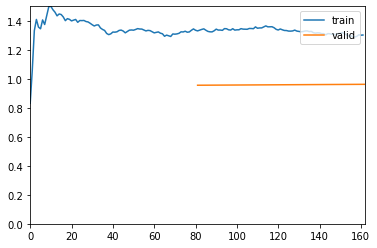

In [62]:
learn.fit_flat_cos(2,lr=1e-3)

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.242093,0.862082,0.486239,0.479452,0.660377,01:35
1,1.151824,0.766089,0.498471,0.488095,0.644654,01:36
2,0.990830,0.733453,0.538226,0.516736,0.776730,01:35
3,0.894577,0.717406,0.486239,0.462810,0.352201,01:35
4,0.818114,0.699607,0.496942,0.489681,0.820755,01:35
5,0.769475,0.706918,0.513761,0.500000,0.018868,01:35
6,0.730601,0.707617,0.512232,0.498113,0.415094,01:35
7,0.731898,0.710122,0.487768,0.483748,0.795597,01:35


Better model found at epoch 0 with valid_loss value: 0.8620821833610535.


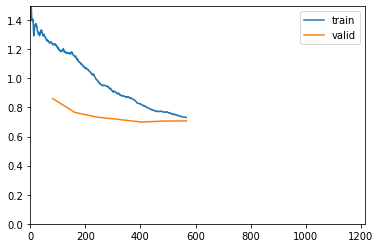

Better model found at epoch 1 with valid_loss value: 0.7660885453224182.
Better model found at epoch 2 with valid_loss value: 0.7334527373313904.
Better model found at epoch 3 with valid_loss value: 0.7174056768417358.
Better model found at epoch 4 with valid_loss value: 0.6996073126792908.
No improvement since epoch 4: early stopping


In [64]:
learn.fit_flat_cos(15,lr=1e-2)

In [65]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [66]:
learn.dls = dlsTest

In [67]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5576208233833313.


(#4) [0.68220055103302,0.5576208233833313,0.5737704918032787,0.8442982456140351]

## Ranger + MixUp

In [68]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [69]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.322592,0.941040,0.513761,0.500000,0.443396,01:14
1,1.269232,0.878463,0.522936,0.511194,0.430818,01:14


Better model found at epoch 0 with valid_loss value: 0.9410396814346313.


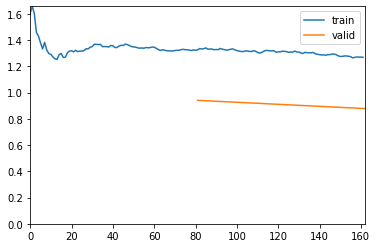

Better model found at epoch 1 with valid_loss value: 0.8784631490707397.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.288450,0.863326,0.521407,0.508651,0.462264,01:36
1,1.277039,0.877968,0.535168,0.525362,0.455975,01:36
2,1.236225,0.862324,0.530581,0.519856,0.452830,01:36
3,1.217780,0.831102,0.535168,0.526119,0.443396,01:36
4,1.195529,0.829461,0.536697,0.533040,0.380503,01:36
5,1.173984,0.808669,0.539755,0.532319,0.440252,01:36
6,1.136249,0.790247,0.542813,0.540426,0.399371,01:36
7,1.094762,0.768066,0.565749,0.562500,0.481132,01:36
8,1.098369,0.775344,0.553517,0.545775,0.487421,01:36
9,1.102148,0.766471,0.561162,0.555556,0.487421,01:36


Better model found at epoch 0 with valid_loss value: 0.863325834274292.


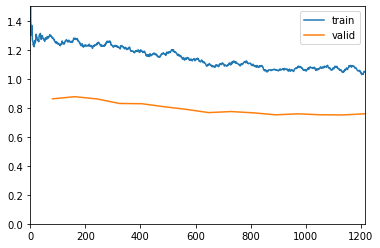

Better model found at epoch 2 with valid_loss value: 0.8623238205909729.
Better model found at epoch 3 with valid_loss value: 0.8311023116111755.
Better model found at epoch 4 with valid_loss value: 0.8294605612754822.
Better model found at epoch 5 with valid_loss value: 0.8086694478988647.
Better model found at epoch 6 with valid_loss value: 0.7902474403381348.
Better model found at epoch 7 with valid_loss value: 0.7680661082267761.
Better model found at epoch 9 with valid_loss value: 0.7664713859558105.
Better model found at epoch 10 with valid_loss value: 0.7525696754455566.
Better model found at epoch 13 with valid_loss value: 0.7518678903579712.


In [70]:
learn.fine_tune(15,freeze_epochs=2)

In [71]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [72]:
learn.dls = dlsTest

In [73]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.524163544178009.


(#4) [0.7938562035560608,0.524163544178009,0.6192052980132451,0.4100877192982456]

## Faltten + MixUp

In [74]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.243707,0.894725,0.562691,0.535874,0.751572,01:14
1,0.946835,0.701109,0.602446,0.645000,0.405660,01:13


Better model found at epoch 0 with valid_loss value: 0.8947252035140991.


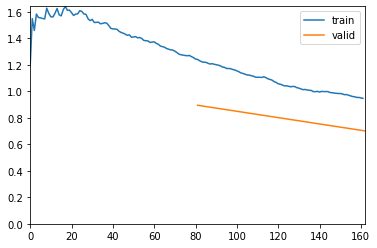

Better model found at epoch 1 with valid_loss value: 0.7011092305183411.


In [75]:
learn.fit_flat_cos(2,lr=1e-3)

In [76]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.148177,13.703806,0.506116,0.461538,0.094340,01:33
1,1.105373,0.861299,0.516820,0.600000,0.018868,01:32
2,1.115996,2.766755,0.513761,0.000000,0.000000,01:32
3,1.285744,6.878122,0.501529,0.492958,0.880503,01:32
4,1.034397,1.514995,0.500000,0.423729,0.078616,01:33


Better model found at epoch 0 with valid_loss value: 13.703805923461914.


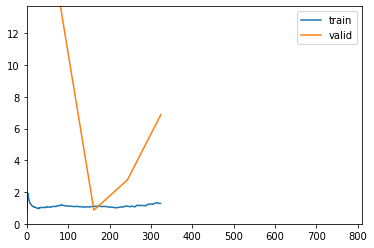

Better model found at epoch 1 with valid_loss value: 0.8612992763519287.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement since epoch 1: early stopping


In [77]:
learn.fit_flat_cos(10,lr=1e-2)

In [78]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [79]:
learn.dls = dlsTest

In [80]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.43246591091156006.


(#4) [1.1665406227111816,0.43246591091156006,0.4375,0.015350877192982455]

## Ranger + Label

In [81]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [82]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.353039,0.976450,0.512232,0.497959,0.383648,01:14
1,1.251413,0.914886,0.507645,0.493711,0.493711,01:14


Better model found at epoch 0 with valid_loss value: 0.9764504432678223.


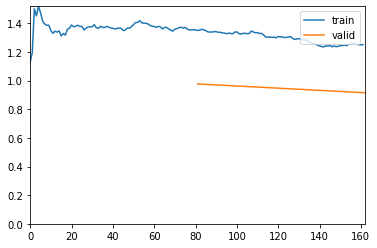

Better model found at epoch 1 with valid_loss value: 0.914886474609375.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.291499,0.900496,0.510703,0.496774,0.484277,01:35
1,1.282529,0.886456,0.516820,0.502825,0.559748,01:35
2,1.270634,0.875506,0.503058,0.489362,0.506289,01:35
3,1.245104,0.857901,0.516820,0.503268,0.484277,01:35
4,1.201299,0.839466,0.529052,0.514881,0.544025,01:35
5,1.167788,0.814752,0.532110,0.517045,0.572327,01:36
6,1.111212,0.802348,0.532110,0.519868,0.493711,01:36
7,1.125168,0.793462,0.548930,0.533724,0.572327,01:36
8,1.071213,0.786951,0.558104,0.541076,0.600629,01:36
9,1.068004,0.775089,0.553517,0.537143,0.591195,01:36


Better model found at epoch 0 with valid_loss value: 0.9004960656166077.


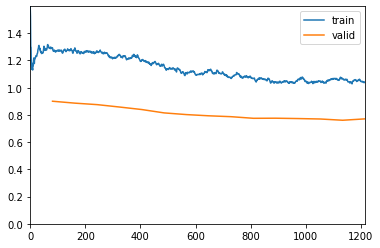

Better model found at epoch 1 with valid_loss value: 0.886456310749054.
Better model found at epoch 2 with valid_loss value: 0.8755059838294983.
Better model found at epoch 3 with valid_loss value: 0.8579007387161255.
Better model found at epoch 4 with valid_loss value: 0.8394662737846375.
Better model found at epoch 5 with valid_loss value: 0.8147515058517456.
Better model found at epoch 6 with valid_loss value: 0.802348256111145.
Better model found at epoch 7 with valid_loss value: 0.7934616804122925.
Better model found at epoch 8 with valid_loss value: 0.7869508862495422.
Better model found at epoch 9 with valid_loss value: 0.7750890254974365.
Better model found at epoch 11 with valid_loss value: 0.7731902003288269.
Better model found at epoch 12 with valid_loss value: 0.7699587941169739.
Better model found at epoch 13 with valid_loss value: 0.7607173323631287.


In [83]:
learn.fine_tune(15,freeze_epochs=2)

In [84]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [85]:
learn.dls = dlsTest

In [86]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5774473547935486.


(#4) [0.7545859813690186,0.5774473547935486,0.6455696202531646,0.5592105263157895]

## Faltten + Label

In [87]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.302180,0.897235,0.588685,0.559322,0.726415,01:13
1,0.992984,0.713979,0.600917,0.576819,0.672956,01:13


Better model found at epoch 0 with valid_loss value: 0.897235095500946.


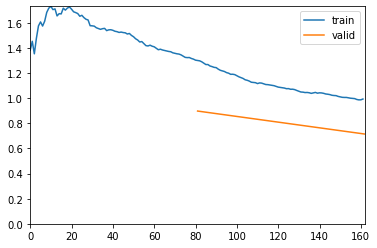

Better model found at epoch 1 with valid_loss value: 0.7139791250228882.


In [88]:
learn.fit_flat_cos(2,lr=1e-3)

In [89]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=7.585775847473997e-07)

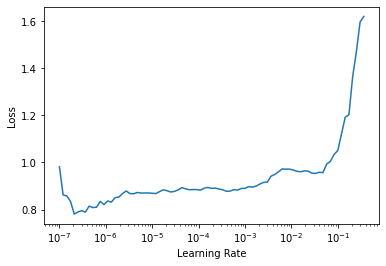

In [90]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.111465,86.534508,0.513761,0.000000,0.000000,01:33
1,1.021072,0.751268,0.516820,0.555556,0.031447,01:32
2,1.023597,1.927783,0.532110,0.583333,0.132075,01:33
3,1.068769,0.849967,0.493884,0.489362,0.940252,01:33
4,0.957260,5593.693848,0.518349,0.509202,0.261006,01:32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 86.53450775146484.


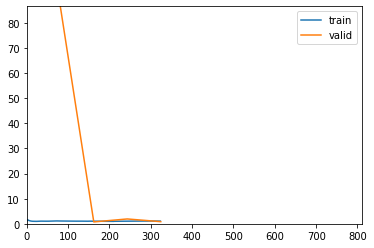

Better model found at epoch 1 with valid_loss value: 0.7512677311897278.
No improvement since epoch 1: early stopping


In [91]:
learn.fit_flat_cos(10,lr=1e-2)

In [92]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [93]:
learn.dls = dlsTest

In [94]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.448574960231781.


(#4) [0.7583589553833008,0.448574960231781,0.72,0.039473684210526314]

## Label + MixUp

In [95]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.337053,1.035701,0.556575,0.553030,0.459119,01:14
1,1.089747,0.819780,0.541284,0.520270,0.726415,01:14


Better model found at epoch 0 with valid_loss value: 1.035701036453247.


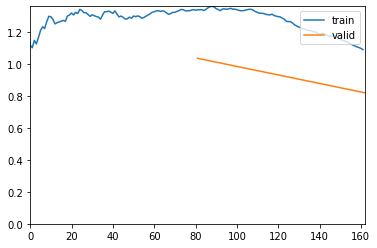

Better model found at epoch 1 with valid_loss value: 0.8197800517082214.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.801541,0.724136,0.550459,0.526786,0.742138,01:35
1,0.780512,0.687777,0.597859,0.590164,0.566038,01:35
2,0.740581,0.678955,0.594801,0.556989,0.814465,01:35
3,0.713738,0.652550,0.608563,0.600649,0.581761,01:35
4,0.692638,0.653187,0.629969,0.783582,0.330189,01:35
5,0.672506,0.622058,0.660550,0.710526,0.509434,01:35
6,0.651751,0.599762,0.695719,0.742857,0.572327,01:35
7,0.649189,0.604169,0.691131,0.756637,0.537736,01:35
8,0.640669,0.602340,0.700306,0.752066,0.572327,01:35
9,0.632228,0.602820,0.694190,0.686709,0.682390,01:35


Better model found at epoch 0 with valid_loss value: 0.7241360545158386.


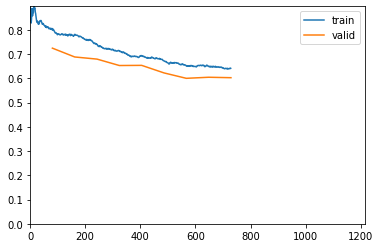

Better model found at epoch 1 with valid_loss value: 0.6877766847610474.
Better model found at epoch 2 with valid_loss value: 0.6789547801017761.
Better model found at epoch 3 with valid_loss value: 0.6525495052337646.
Better model found at epoch 5 with valid_loss value: 0.6220577359199524.
Better model found at epoch 6 with valid_loss value: 0.5997615456581116.
No improvement since epoch 6: early stopping


In [96]:
learn.fine_tune(15,freeze_epochs=2)

In [97]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [98]:
learn.dls = dlsTest

In [99]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7125154733657837.


(#4) [0.6053778529167175,0.7125154733657837,0.8393939393939394,0.6074561403508771]